In [1]:
import random
import os

def load_casia_b_data(dataset_path, train_ratio=0.7):
    """
    Load CASIA-B dataset and split sequences from each subject into training and testing
    Args:
      train_ratio: Proportion of sequences per subject to use for training (0.7 = 70%)
    Returns:
      train_data: List of dicts for training sequences (mixed from all subjects)
      test_data: List of dicts for testing sequences (mixed from all subjects)
    """
    # Get all subjects (1-124)
    all_subjects = [f"{i:03d}" for i in range(1, 125)]
    
    # Define conditions and sequences
    conditions = {
        'nm': ['nm-01','nm-02','nm-03','nm-04','nm-05','nm-06'],
        'bg': ['bg-01','bg-02'],
        'cl': ['cl-01','cl-02']
    }
    
    # Define views (only 90 degrees)
    views = ["090"]
    
    # Gather all entries first
    all_entries = []
    for subject in all_subjects:
        subj_path = os.path.join(dataset_path, subject)
        if not os.path.isdir(subj_path):
            continue
        for cond, seqs in conditions.items():
            for seq in seqs:
                seq_path = os.path.join(subj_path, seq)
                if not os.path.isdir(seq_path):
                    continue
                for view in views:
                    view_path = os.path.join(seq_path, view)
                    if not os.path.isdir(view_path):
                        continue
                    # Count PNG frames
                    frames = [f for f in os.listdir(view_path) if f.endswith('.png')]
                    all_entries.append({
                        'subject': subject,
                        'condition': cond,
                        'sequence': seq,
                        'view': view,
                        'path': view_path,
                        'num_frames': len(frames)
                    })
    
    # Split sequences per subject
    train_data = []
    test_data = []
    
    for subject in all_subjects:
        subject_entries = [e for e in all_entries if e['subject'] == subject]
        if len(subject_entries) == 0:
            continue
            
        random.shuffle(subject_entries)
        split_idx = int(len(subject_entries) * train_ratio)
        
        train_data.extend(subject_entries[:split_idx])
        test_data.extend(subject_entries[split_idx:])
    
    print(f"Loaded {len(train_data)} training sequences from {len(all_subjects)} subjects")
    print(f"Loaded {len(test_data)} testing sequences from {len(all_subjects)} subjects")
    
    return train_data, test_data


In [2]:
train_data, test_data = load_casia_b_data(r'D:\vit study\Machine Learning\Gait\CASIA - B\CASIA - B\GaitDatasetB-silh\GaitDatasetB-silh\GaitDatasetB-silh',train_ratio=0.7)

Loaded 861 training sequences from 124 subjects
Loaded 369 testing sequences from 124 subjects


In [3]:
train_data[0]

{'subject': '001',
 'condition': 'nm',
 'sequence': 'nm-06',
 'view': '090',
 'path': 'D:\\vit study\\Machine Learning\\Gait\\CASIA - B\\CASIA - B\\GaitDatasetB-silh\\GaitDatasetB-silh\\GaitDatasetB-silh\\001\\nm-06\\090',
 'num_frames': 59}

In [4]:
import pandas as pd

# Convert to DataFrame for easy analysis
train_df = pd.DataFrame(train_data)
test_df  = pd.DataFrame(test_data)

# 1. Number of sequences per condition
print("Train sequences per condition:")
print(train_df['condition'].value_counts(), "\n")

print("Test sequences per condition:")
print(test_df['condition'].value_counts(), "\n")


Train sequences per condition:
condition
nm    512
cl    178
bg    171
Name: count, dtype: int64 

Test sequences per condition:
condition
nm    226
bg     75
cl     68
Name: count, dtype: int64 



In [5]:

stats = train_df.groupby(['condition','view'])['num_frames'].agg(['count']).unstack(fill_value=0)
print("\nTrain sequences and mean lengths by condition & view:\n", stats)



Train sequences and mean lengths by condition & view:
           count
view        090
condition      
bg          171
cl          178
nm          512


In [6]:
classes=train_df["subject"].unique()
classes

array(['001', '002', '003', '004', '006', '007', '008', '009', '010',
       '011', '012', '013', '014', '015', '016', '017', '018', '019',
       '020', '021', '022', '023', '024', '025', '026', '027', '028',
       '029', '030', '031', '032', '033', '034', '035', '036', '037',
       '038', '039', '040', '041', '042', '043', '044', '045', '046',
       '047', '048', '049', '050', '051', '052', '053', '054', '055',
       '056', '057', '058', '059', '060', '061', '062', '063', '064',
       '065', '066', '067', '068', '069', '070', '071', '072', '073',
       '074', '075', '076', '077', '078', '079', '080', '081', '082',
       '083', '084', '085', '086', '087', '088', '089', '090', '091',
       '092', '093', '094', '095', '096', '097', '098', '099', '100',
       '101', '102', '103', '104', '105', '106', '107', '108', '109',
       '110', '111', '112', '113', '114', '115', '116', '117', '118',
       '119', '120', '121', '122', '123', '124'], dtype=object)

In [7]:
train_df["sequence"].unique()


array(['nm-06', 'bg-02', 'nm-05', 'nm-04', 'bg-01', 'cl-01', 'nm-03',
       'nm-01', 'cl-02', 'nm-02'], dtype=object)

In [8]:
lengths = [len(os.listdir(ent['path'])) for ent in train_data]
print(min(lengths), max(lengths))


42 86


In [9]:
# List entries with zero frames
empty_train = [e for e in train_data if e['num_frames'] <= 30]
empty_test  = [e for e in test_data  if e['num_frames'] <= 30]

print(f"Empty training sequences: {len(empty_train)}")
for e in empty_train:
    print(f"Subject {e['subject']}, Condition {e['condition']}, Sequence {e['sequence']}, View {e['view']}")

print(f"\nEmpty testing sequences: {len(empty_test)}")
for e in empty_test:
    print(f"Subject {e['subject']}, Condition {e['condition']}, Sequence {e['sequence']}, View {e['view']}")


Empty training sequences: 0

Empty testing sequences: 0


In [10]:
MIN_SEQ_LEN = 30

# Filter training data
filtered_train = []
for e in train_data:
    if e['num_frames'] >= MIN_SEQ_LEN:
        filtered_train.append(e)

# Filter testing data
filtered_test = []
for e in test_data:
    if e['num_frames'] >= MIN_SEQ_LEN:
        filtered_test.append(e)

# Update the original lists
train_data = filtered_train
test_data = filtered_test

print(f"Training sequences after filtering: {len(train_data)}")
print(f"Testing sequences after filtering: {len(test_data)}")


Training sequences after filtering: 861
Testing sequences after filtering: 369


391
Subject: 057, Condition: nm, Sequence: nm-06, View: 090, Number of frames: 61


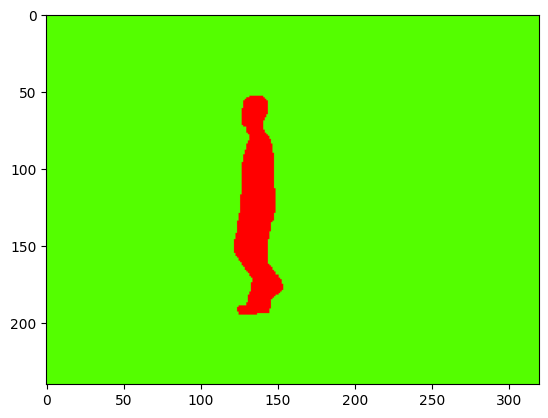

In [11]:
import matplotlib.pyplot as plt
import os
import math
import random

rand_num = random.choice(range(len(train_data)))
print(rand_num)
sample=train_data[rand_num]
sample_path=sample["path"]
sample_frames=os.listdir(sample_path)
image=plt.imread(os.path.join(sample_path,random.choice(sample_frames)))
print(f"Subject: {sample['subject']}, Condition: {sample['condition']}, Sequence: {sample['sequence']}, View: {sample['view']}, Number of frames: {sample['num_frames']}")  
plt.imshow(image, cmap='prism_r')


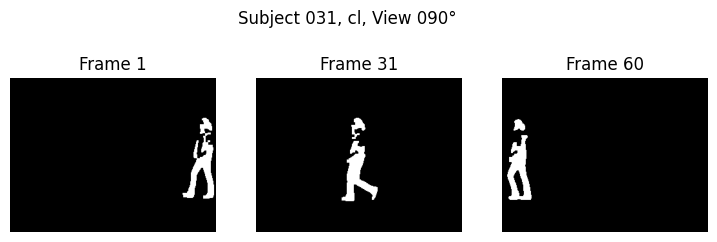

In [12]:
import matplotlib.pyplot as plt
import os

# Pick the first training sequence
rand_num = random.choice(range(len(train_data)))
sample = train_data[rand_num]
frame_files = sorted(f for f in os.listdir(sample['path']) if f.endswith('.png'))

# Select three frames evenly spaced through the sequence
indices = [0, len(frame_files)//2, len(frame_files)-1]
selected = [frame_files[i] for i in indices]

# Load and plot
plt.figure(figsize=(9, 3))
for i, fname in enumerate(selected):
    img = plt.imread(os.path.join(sample['path'], fname))
    plt.subplot(1, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Frame {indices[i]+1}")
plt.suptitle(f"Subject {sample['subject']}, {sample['condition']}, View {sample['view']}°")
plt.show()


In [13]:
import tensorflow as tf

IMG_HEIGHT = 280
IMG_WIDTH  = 210



def preprocess_frame(image_path):
    """
    Efficiently reads, decodes, resizes, and normalizes a grayscale image tensor.
    Keeps all operations in TensorFlow graph for pipelining.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  # grayscale
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method=tf.image.ResizeMethod.BILINEAR)
    image = tf.cast(image, tf.float32) / 255.0      # Convert to float32 and normalize
    return image

"""def preprocess_frame(image_path):
    
    #Reads an image file, decodes, resizes, and normalizes it.
    
    # Read & decode
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)            # grayscale
    # Resize
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize to [0,1]
    image = image / 255.0
    return image
"""

'def preprocess_frame(image_path):\n    \n    #Reads an image file, decodes, resizes, and normalizes it.\n    \n    # Read & decode\n    image = tf.io.read_file(image_path)\n    image = tf.image.decode_png(image, channels=1)            # grayscale\n    # Resize\n    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])\n    # Normalize to [0,1]\n    image = image / 255.0\n    return image\n'

In [14]:
preprocess_frame(os.path.join(sample_path, sample_frames[0]))

<tf.Tensor: shape=(280, 210, 1), dtype=float32, numpy=
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], shape=(280, 210, 1), dtype=float32)>

In [15]:
import os
import numpy as np
import tensorflow as tf



SEQ_LEN    = 40



def build_dataset(entries):
    X_list = []
    y_list = []
    
    # Create subject to label mapping for all subjects in entries
    unique_subjects = sorted(set(e['subject'] for e in entries))
    subject_to_label = {subj: idx for idx, subj in enumerate(unique_subjects)}
    
    for ent in entries:
        # Get sorted frame file names
        files = sorted([f for f in os.listdir(ent['path']) if f.endswith('.png')])
        # Truncate or pad to SEQ_LEN
        files = files[:SEQ_LEN]
        while len(files) < SEQ_LEN:
            files.append(files[-1])
        # Preprocess frames
        seq = []
        for fname in files:
            img_path = os.path.join(ent['path'], fname)
            img = preprocess_frame(img_path)
            seq.append(img)
        seq_array = np.stack(seq, axis=0)  # (SEQ_LEN, H, W, 1)
        X_list.append(seq_array)
        y_list.append(subject_to_label[ent['subject']])  # mapped label
    
    # Stack all sequences
    X = np.stack(X_list, axis=0)  # (N, SEQ_LEN, H, W, 1)
    y = np.array(y_list, dtype=np.int32)
    return X, y


# Build datasets
X_train, y_train = build_dataset(train_data)
X_test, y_test = build_dataset(test_data)


print("Train data shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)



Train data shape: (861, 40, 280, 210, 1)
Train labels shape: (861,)
Test data shape: (369, 40, 280, 210, 1)
Test labels shape: (369,)


In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Shapes
print("X_train shape:", X_train.shape)  # (N, SEQ_LEN, 64, 44, 1)
print("y_train shape:", y_train.shape)
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Sequence length: {X_train.shape[1]}")
print(f"Image size: {X_train.shape[2]} x {X_train.shape[3]}")
print(f"Number of unique subjects: {len(np.unique(y_train))}")

# Unique subjects in train
unique, counts = np.unique(y_train, return_counts=True)
print("Subjects:", unique)
print("Sequences per subject:", counts)




X_train shape: (861, 40, 280, 210, 1)
y_train shape: (861,)
Number of training samples: 861
Sequence length: 40
Image size: 280 x 210
Number of unique subjects: 123
Subjects: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122]
Sequences per subject: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7]


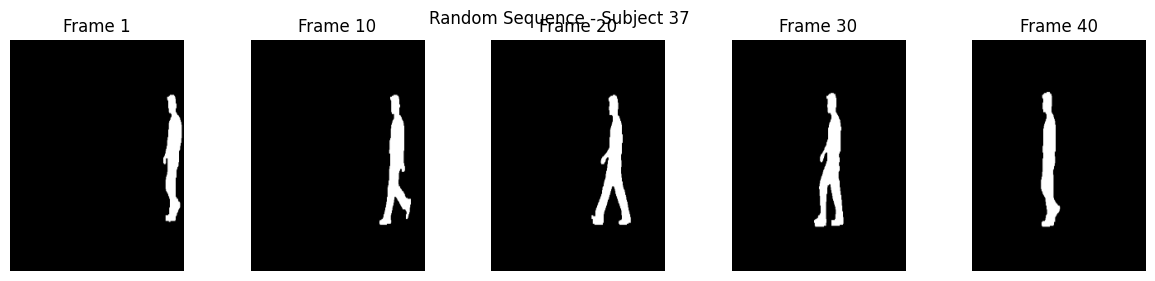

In [17]:
import random

# Pick a random sequence and show five frames
i = random.randint(0, X_train.shape[0] - 1)
seq = X_train[i]  # shape: (SEQ_LEN, 64, 44, 1)
label = y_train[i]

plt.figure(figsize=(15,3))
indices = np.linspace(0, seq.shape[0] - 1, 5, dtype=int)
for idx, frame_num in enumerate(indices):
    plt.subplot(1, 5, idx+1)
    plt.imshow(seq[frame_num,:,:,0], cmap='gray')
    plt.title(f"Frame {frame_num+1}")
    plt.axis('off')
plt.suptitle(f"Random Sequence - Subject {label}")
plt.show()


In [18]:
import numpy as np

# Save training data
np.save('processed_90/X_train.npy', X_train)
np.save('processed_90/y_train.npy', y_train)

# Save testing data
np.save('processed_90/X_test.npy', X_test)
np.save('processed_90/y_test.npy', y_test)


FileNotFoundError: [Errno 2] No such file or directory: 'processed_90/X_train.npy'

In [ ]:
import numpy as np

# Load training data
X_train = np.load('processed_90/X_train.npy')
y_train = np.load('processed_90/y_train.npy')

# Load testing data
X_test = np.load('processed_90/X_test.npy')
y_test = np.load('processed_90/y_test.npy')

print("Shapes after loading:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Shapes after loading:
X_train: (863, 30, 128, 88, 1)
y_train: (863,)
X_test: (372, 30, 128, 88, 1)
y_test: (372,)


In [19]:
import numpy as np

all_labels = np.concatenate([y_train, y_test])
num_classes = len(np.unique(all_labels))
print(f"Number of unique subjects (classes): {num_classes}")


Number of unique subjects (classes): 123


In [20]:
import tensorflow as tf

y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes)
y_test_onehot

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], shape=(369, 123))

In [21]:
from tensorflow.keras import layers, models
NUM_CLASSES=124
SEQ_LEN=40
HEIGHT=280
WIDTH=210
CHANNELS=1
model = models.Sequential([
    layers.Input(shape=(SEQ_LEN, HEIGHT, WIDTH, CHANNELS)),

    # Conv Block 1
    layers.Conv3D(32, (3, 3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling3D((1, 2, 2)),

    # Conv Block 2
    layers.Conv3D(64, (3, 3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling3D((1, 2, 2)),

    # Conv Block 3
    layers.Conv3D(128, (3, 3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling3D((1, 2, 2)),

    # Use GlobalAveragePooling3D instead of Flatten for flexible input size
    layers.GlobalAveragePooling3D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 40, 280, 210,   │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 280, 210,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 40, 280, 210,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 40, 140, 105,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 40, 140, 105,   │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 40, 140, 105,   │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 40, 140, 105,   │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 40, 70, 52, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 40, 70, 52,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 40, 70, 52,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 40, 70, 52,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 40, 35, 26,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 124)            │        15,996 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,972 (1.19 MB)

 Trainable params: 310,524 (1.18 MB)

 Non-trainable params: 448 (1.75 KB)

In [23]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set training parameters
BATCH_SIZE = 16
EPOCHS = 50

# Callbacks for better training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7)
]

# Train the model
print("Starting training...")
history = model.fit(
    [X_train,y_train],                  # Dataset with batches and preprocessing
    validation_data=[X_test,y_test],   # Dataset for validation
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)
print("Training completed!")


print("Training completed!")


Starting training...


MemoryError: Unable to allocate 7.54 GiB for an array with shape (861, 40, 280, 210, 1) and data type float32